# Probability and Information Theory

## Steps

1. Understand the problem and the mathematical model and generate data
2. Load the (generated) data and get an overview
3. Try to fit parametric probability distributions
4. Joint  and conditional probabilities, chain rule and Bayes' Theorem
5. Self-entropy of an event and entropy of a distribution

## Understand the problem and the mathematical model and generate data

From [1] we learned the following simplified model for simulating and understanding the spreading of diseases. 

![Epidemic process](img/epidemic_process.png)

A fraction of $\beta$ of the susceptible indivisuals $S$ gets infected each unit of time, say each day. A fraction $\mu$ of the infected recover. A simple generalization is a third parameter $\nu$ and the assumption that only $\nu\mu$ individuals recover, while ${1-\nu}\mu$ individuals die.

This leads to the following system of ordinary differencial equations (ODEs):

\begin{align}
\frac{\delta S}{\delta t} & = -\beta S(t)I(t)\\
\frac{\delta I}{\delta t} & = \beta S(t)I(t) -\mu I(t)\\
\frac{\delta R}{\delta t} & = \nu\mu I(t)\\
\frac{\delta D}{\delta t} & = (1-\nu)\mu I(t)
\end{align}

Given starting values of $S(0)=99, I(0)=1, R(0)=D(0)=0$ and parameter values for $\beta=0.05\%, \mu=1.75\%, \nu=99\%$, we can simulate this system of ODEs.

In `Matlab`, we use the ordinary differencial equation solver `ode45`.

In [122]:
%%file virusSpreading.m
function res = virusSpreading(t, y, beta, mu, nu)
    S=y(1);
    I=y(2);
    R=y(3);
    D=y(4);
    
    res(1,1)=-beta*S*I;
    res(2,1)=beta*S*I-mu*I;
    res(3,1)=nu*mu*I;
    res(4,1)=(1-nu)*mu*I;
end

Overwriting virusSpreading.m


In [123]:
%%file simVirusSpreading.m
function res = simVirusSpreading(beta, verbose)
    S0 =99;
    I0 =1;
    R0 = 0;
    D0 = 0;
    y0 = [S0, I0, R0, D0]';
    t_span = [0 500];
    mu = 0.0175;
    nu = 0.99;
    [tSol, ySol] = ode45(@(t,y) virusSpreading(t, y, beta, mu, nu), t_span, y0);
    if verbose
        plot(tSol, ySol);
        legend("Susceptible","Infected","Recovered","Dead");
    end
    res = [tSol, ySol];
end

Overwriting simVirusSpreading.m


In [ ]:
format compact
beta = 0.0005; %0.05%
simVirusSpreading(beta, true);

Note that the development highly depends on the parameter $\beta$. So, if all behave well, the infection risk drops and the infection spreading slows down. Inversely, if we misbehave and increase the risk of infection, the infection spreads faster. Here simulations with $\beta = 0.03\%$ and $\beta = 0.07\%$, respectively.

In [ ]:
beta = 0.0003;
simVirusSpreading(beta, true);

In [ ]:
beta = 0.0007;
simVirusSpreading(beta, true);

Of course, the exact parameters values for $\beta, \mu, \nu$ are not known but can only be approximated from observations. The ODE model is an abstraction of the real process, which depends on deterministic but unknown variables and randomness. Therefore, it makes sense to understand disease spreading as a **random process.**

We will generate some observations from this process from different countries and then forget about the process and only work with the observations.

Therefore, we assume that $\beta$ distributes normally around a mean of $\bar \beta = 0.05\%$ with a standard deviation of $\sigma = 0.01\%$. We generate the data for $50$ countries. However, we are only "observing" $8$ new features.

1. The numbers $N_{50}, N_{150}, N_{300}$ of infected after $50, 150, 300$ days, resp. 
2. The corresponding numbers of new infections on that day $D_{50}, D_{150}, D_{300}$.
3. The time $T_{peak}$ to peak infection.
4. The total number of casulties $X_{500}$ after $500$ days.

In [ ]:
countries = 150;
verbose = false;
export_raw_data = true;
if verbose
    countries=1;
end
if export_raw_data
    raw_features = zeros(4*countries, 501);
    raw_features(1,:) = 1:501;
end
features = zeros(countries,8);
rng('default')  % For reproducibility
betas = normrnd(0.0005,0.0001,[1,countries]);
for i=1:countries
    res = simVirusSpreading(betas(i), false);
    times = res(:,1);
    % Add randomness to the observations
    rand_res = zeros(size(res,1),5);
    rand_res(:,1) = times;
    for j=2:5
        rand_res(:,j) = arrayfun(@(x) normrnd(0,0.025*x)+x, res(:,j));
    end
    if verbose
        fprintf("Beta = %.3f%%\n",betas(1)*100);
        plot(times,[res(:,2) rand_res(:,2), res(:,3) rand_res(:,3),res(:,4) rand_res(:,4),res(:,5) rand_res(:,5)]);        
    end
    if export_raw_data
        days = [0:500];
        for var = 2:5
            F = griddedInterpolant(rand_res(:,1),rand_res(:,var));
            raw_features((i-1)*4+var,:)=F(days);
        end
    end
    ti = times(times<=50);
    n_50 = rand_res(length(ti),3);
    d_50 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=150);
    n_150 = rand_res(length(ti),3);
    d_150 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=300);
    n_300 = rand_res(length(ti),3);
    d_300 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    [M,ii] = max(rand_res(:,3));
    t_peak = times(ii);
    if verbose
        fprintf("n_50=%.4f, n_150=%.4f, n_300=%.4f\nd_50=%.4f, d_150=%.4f, d_300=%.4f\nt_peak=%.4f\nx_500=%.4f\n",n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5) );
    end
    features(i,:)=[n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5)];
end
writematrix(features,'../2020 DL data/epidemic_process.csv');
if export_raw_data
    writematrix(raw_features,'../2020 DL data/epidemic_process_raw_data.csv');
end

## Load the (generated) data and get an overview

This is your starting point. Load the observation data.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st


In [2]:
# Load Data
features = np.loadtxt('data/epidemic_process.csv', delimiter=",");

In [3]:
# Explore data
print(features.shape)

(50, 8)


Plot the emperical **cumulative probability distributions** (CDFs) of the **random variables** (features).


Stats:
min: 1.12924548216732 
max: 18.0925217381952 
mean: 5.510799932725158 
median: 4.42272992534525 
std: 3.362285673435535


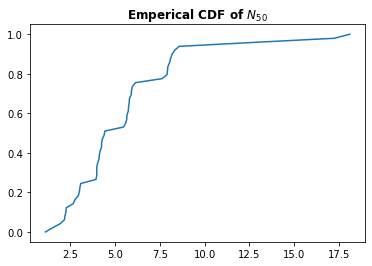


Stats:
min: 1.50799302634801 
max: 35.5759048599318 
mean: 26.084033433130713 
median: 30.329100263864497 
std: 9.254859721163191


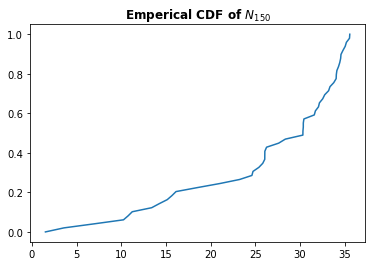


Stats:
min: 1.86808769555416 
max: 15.4667915790547 
mean: 8.145337883057705 
median: 7.34734543412002 
std: 3.6040461200663736


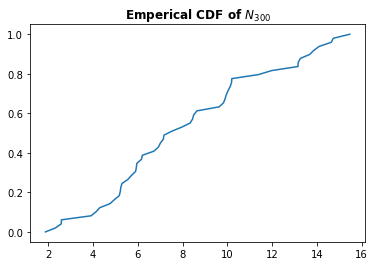


Stats:
min: 0.0329721610814671 
max: 3.94019496952329 
mean: 1.0976084202155847 
median: 0.952190554664612 
std: 0.7763794279146738


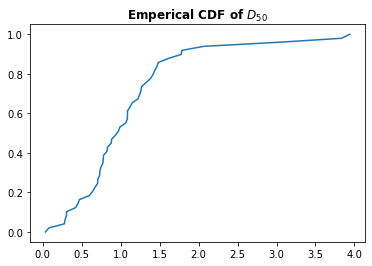


Stats:
min: -4.5398007538944 
max: 3.84615467569941 
mean: 0.5070426726684459 
median: 1.2294473457215251 
std: 2.171643414043585


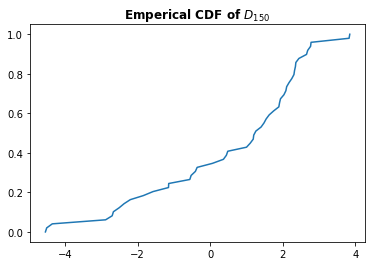


Stats:
min: -2.24431732600528 
max: 0.0309620569803597 
mean: -1.2498222689663712 
median: -1.278830723041285 
std: 0.5350603552002774


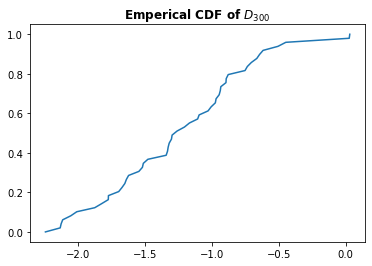


Stats:
min: 92.3416178105711 
max: 445.305297091955 
mean: 167.16545499001558 
median: 150.599951175257 
std: 62.44270790018697


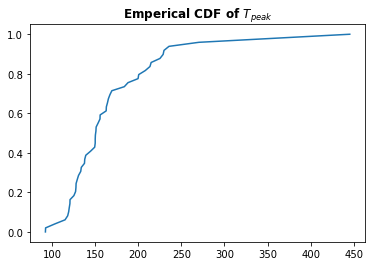


Stats:
min: 0.147540704286552 
max: 1.0030705664339 
mean: 0.8987742105081916 
median: 0.9392001196463056 
std: 0.13987283222086144


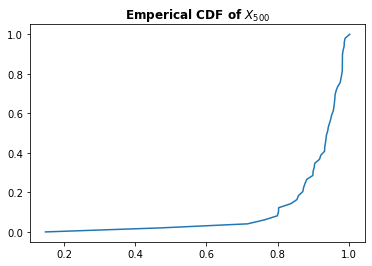

In [4]:
s = np.sort(features,axis=0)
minvals = s[0,:]
maxvals = s[len(s)-1,:]
meanvals = np.mean(s,axis=0)
medianvals = np.median(s,axis=0)
stdvals = np.std(s,axis=0)
title = "Emperical CDF of "
titles = [ '$N_{50}$','$N_{150}$','$N_{300}$','$D_{50}$', '$D_{150}$','$D_{300}$','$T_{peak}$','$X_{500}$']

for cols in range(s.shape[1]):
    print("\nStats:\nmin:",minvals[cols],"\nmax:",maxvals[cols],"\nmean:",meanvals[cols],"\nmedian:",medianvals[cols],"\nstd:",stdvals[cols])
    plt.title(title + titles[cols],fontweight='bold')
    plt.plot(s[:,cols],np.arange(s.shape[0])/(s.shape[0]-1))
    plt.show()


Recall, the sample `mean` value is an approximation of the expected value, or **expectation** of the random variable. The sample **variance** is the square of the sample standard deviation `std`.    

Check the correlation between the features.

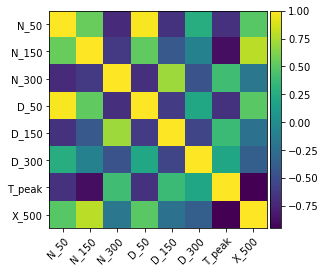

In [43]:
rho = np.corrcoef(features,rowvar=False);
ax = plt.subplot(111)
im = ax.imshow(rho)
label_titles = [ 'N_50','N_150','N_300','D_50', 'D_150','D_300','T_peak','X_500']
ax.set_xticks(np.arange(len(label_titles)))
ax.set_yticks(np.arange(len(label_titles)))
ax.set_xticklabels(label_titles)
ax.set_yticklabels(label_titles)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

Recall, the (sample) correlation of two (samples of) random variables $X$ and $Y$ their (sample) **covariance** normalized (divided) by the product of their (sample) standard deviation.

*Discuss your findings. Your answer goes here.*
We can see across the diagonal, that each feature is perfectly related with itself. Features with 0 are independent, features with negative correlation have a negative linear relationship and positve correlation have a positive linear relationship. The stronger the value of the relationship, the stronger the correlation.

Let us examine N50/D50, N150/D150, and N300/D300. We can see that correlation starts very strong in the positive, and then moves into a weaker negative relationship. This shows that the number of people in the infected group compared to the number of people that have newly arrived in the infected group starts strong in the beginning but then diminshes. We also see that the net new infections diminishes around 150 days with people both leaving the infected group and entering the group. By 300, we primarily have negative flow of people out of the infected group, which supports the negative correlation.

This is backed up by the correlation with t_peak, where the n50 and n150 groups have a strong negative correlation. This is because they are still primarily adding infected, and therefore cannot be close to peaking. The n300 group has a medium positive correlation with the peak because it has most likely added as much to the infected as it can and is in a strong negative outflow from the infected group. The cdf of d300 shows that it is very uncommon to add a new infected at that time, and is primarily losing infected.

The strongest correlation with X500 is the peak feature because it can be assumed that casualties should have happened by the time of the peak, although we do not have data for when the casualties actually occurred. 



## Try to fit parametric probability distributions

We go through a set of common probability distributions and try to fit any of them  to the data. We use the Chi-square and the Kolmogorov-Smirnov tests to check the goodness of fit. 

*Note that fitting and testing using the same data is actually not quite correct. We should use cross-validation.*

In [6]:

# def distribution_fitting(feature):
#     distnames =["Poisson", "Exponential", "Gamma", "ExtremeValue", "Kernel"]
#     values_must_be_positive =["Poisson", "Exponential", "Gamma"]
#     x=feature.T
#     x_min = np.min(x)
#     x_max = np.max(x)
#     x_values = np.linspace(x_min, x_max)
#     for distname in distnames:
#         if x_min <0 and np.any(values_must_be_positive == distname):#not isempty(find(strcmp(distname, values_must_be_positive)))
#             continue
#         distname = char(dn);
#         pd = fitdist(x.',distname);
#         res1=kstest(x, 'CDF', pd); 
#         res2=chi2gof(x, 'CDF', pd);
#         if (~res1 && ~res2)
#             fprintf('%s with 5%% significance level\r',distname);
#             cdfplot(x)
#             hold on
#             plot(x_values,cdf(pd,x_values),'r-')
#             plot(x_values,pdf(pd,x_values),'g-')
#             legend('Empirical CDF',[distname ' CDF'],[distname ' PDF'],'Location','best');
#             %title(['Empirical CDF and ', [distname ' CDF/PDF']);
#             hold off 
#             return;
#         else 
#             fprintf('Not %s with 5%% significance level\n',distname);
#         end
#     end
# end

In [61]:
def distribution_fitting(feature,title=""):
    #distnames =["Poisson", "Exponential", "Gamma", "ExtremeValue", "Kernel"]
    distclasses =[st.expon, st.gamma, st.genextreme]
    distnames =['expon', 'gamma', 'genextreme']
    #values_must_be_positive =["Poisson", "Exponential", "Gamma"]
    values_must_be_positive =[st.expon, st.gamma]
    feature_min = np.min(feature)
    feature_max = np.max(feature)
    feature_values = np.linspace(feature_min, feature_max, feature.shape[0])
    
    for distname, distclass in zip(distnames, distclasses):
        
        if feature_min <0 and distname in values_must_be_positive:
            continue
        else:
            
            args = distclass.fit(feature)
            kt = st.kstest(feature,distname,args)
            
            
            
            
            
            # Set up 50 bins for chi-square test
            # Observed data will be approximately evenly distrubuted aross all bins
            
            percentile_bins = np.linspace(0, 100, 51)
            
            percentile_cutoffs = np.percentile(feature, percentile_bins)
            
            observed_frequency, bins = (np.histogram(feature, bins=percentile_cutoffs))
            
            cum_observed_frequency = np.cumsum(observed_frequency)
            
            
            # fail to reject null hypothesis that they come from same distribution
            if(kt.pvalue > .05):
                print("Accept the null hypothesis. Confident it DOES come from ",distname)
                print(distname)
                print("fit args:",args)
                print("kolmogrov:",kt)
                featuresorted = np.sort(feature)
                plt.plot(featuresorted,np.arange(featuresorted.shape[0])/(featuresorted.shape[0]-1),label="empirical cdf")
                plt.plot(feature_values,distclass.cdf(feature_values,*args),label=distname+" cdf")
                plt.plot(feature_values, distclass.pdf(feature_values,*args),label=distname+" pdf")
                plt.legend()#["empirical cdf", "gamma cdf", "gamma pdf"])
                plt.title(title,fontweight='bold')
                plt.show()
            else:
                # reject null hypothesis that they come from same distribution. They do not come from same distribution
                print("Reject the null hypothesis. Confident it DOES NOT come from",distname)
                continue
                
            
            
                


0
Reject the null hypothesis. Confident it DOES NOT come from expon
Accept the null hypothesis. Confident it DOES come from  gamma
gamma
fit args: (2.1739534330235553, 0.8663939748298817, 2.1363713273967884)
kolmogrov: KstestResult(statistic=0.10954658718825444, pvalue=0.549146181979034)


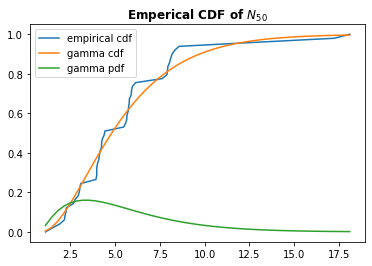

Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (-0.1576646663043923, 3.955832823506072, 2.04799320973682)
kolmogrov: KstestResult(statistic=0.10580729786458315, pvalue=0.5929892920746145)


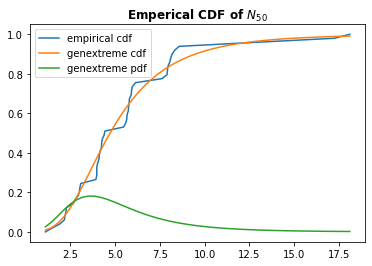


1
Reject the null hypothesis. Confident it DOES NOT come from expon
Reject the null hypothesis. Confident it DOES NOT come from gamma
Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (1.1043653516891614, 25.360698320215405, 11.281320162811323)
kolmogrov: KstestResult(statistic=0.09845413421706728, pvalue=0.6807962955061791)


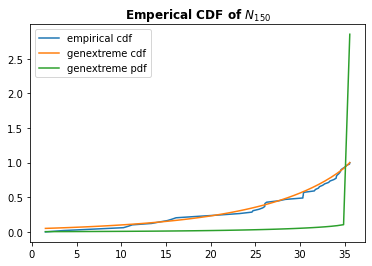


2
Reject the null hypothesis. Confident it DOES NOT come from expon
Accept the null hypothesis. Confident it DOES come from  gamma
gamma
fit args: (6.778259638472212, -1.4798803297973264, 1.4200133660091883)
kolmogrov: KstestResult(statistic=0.08248683752994002, pvalue=0.8578583269948439)


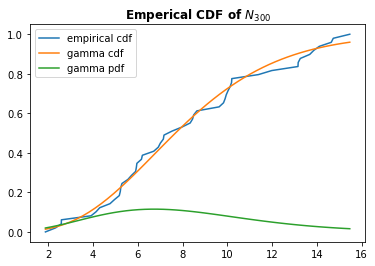

Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (0.15923762132061736, 6.678957590414377, 3.249707484513096)
kolmogrov: KstestResult(statistic=0.09294459016467005, pvalue=0.7457427038000508)


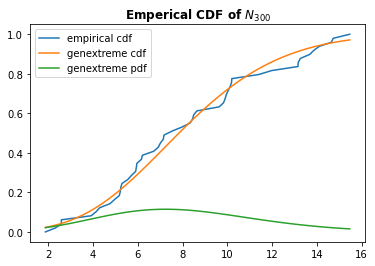


3
Reject the null hypothesis. Confident it DOES NOT come from expon
Accept the null hypothesis. Confident it DOES come from  gamma
gamma
fit args: (2.733899868238918, -0.08696927070412444, 0.4332939161664512)
kolmogrov: KstestResult(statistic=0.10630111920399565, pvalue=0.5871476553507307)


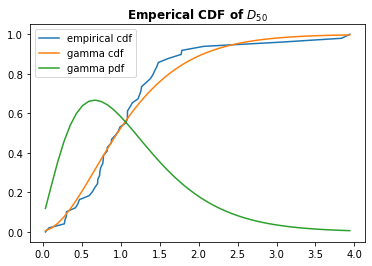

Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (-0.10715612734229667, 0.7534189627585046, 0.49340566919399403)
kolmogrov: KstestResult(statistic=0.0900096651434627, pvalue=0.7791588383732059)


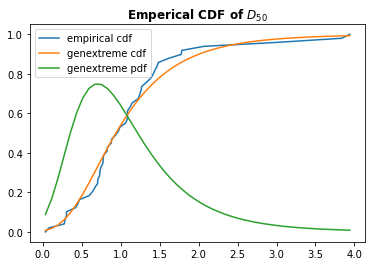


4
Reject the null hypothesis. Confident it DOES NOT come from expon
Accept the null hypothesis. Confident it DOES come from  gamma
gamma
fit args: (250.77542645340282, -35.20218726299541, 0.14228883257403302)
kolmogrov: KstestResult(statistic=0.1790902835240708, pvalue=0.07112691879375388)


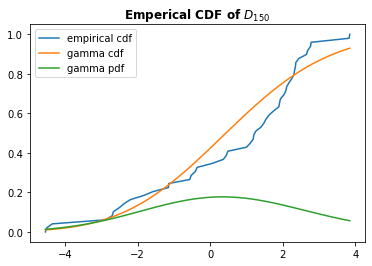

Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (0.5985644770709595, 0.08515655630859556, 2.36333034931815)
kolmogrov: KstestResult(statistic=0.10548264421965797, pvalue=0.5968367350222998)


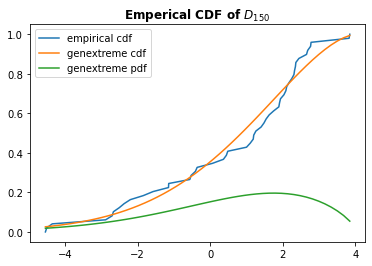


5
Reject the null hypothesis. Confident it DOES NOT come from expon
Accept the null hypothesis. Confident it DOES come from  gamma
gamma
fit args: (45.264341645989965, -4.860443118975856, 0.07976752677669954)
kolmogrov: KstestResult(statistic=0.07499642578309806, pvalue=0.9212049705458767)


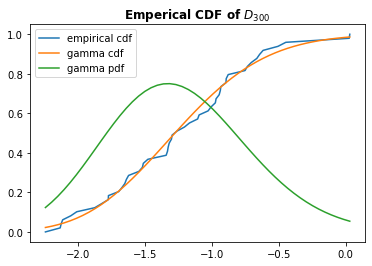

Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (0.21894727625781268, -1.4541442340164155, 0.5132205635018051)
kolmogrov: KstestResult(statistic=0.07009624160454364, pvalue=0.9521944834714541)


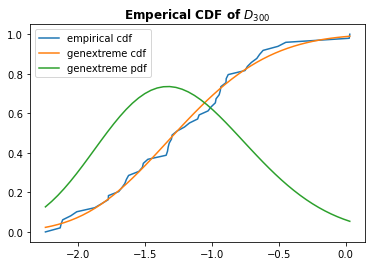


6
Reject the null hypothesis. Confident it DOES NOT come from expon
Accept the null hypothesis. Confident it DOES come from  gamma
gamma
fit args: (2.0543913377341223, 87.22263685752287, 38.9131471826004)
kolmogrov: KstestResult(statistic=0.11219413944731293, pvalue=0.5187808461888501)


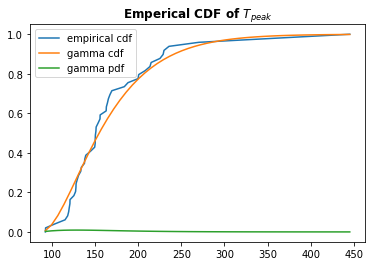

Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (-0.192539215177747, 139.08322908707058, 34.321980725567144)
kolmogrov: KstestResult(statistic=0.0775339768044333, pvalue=0.9017743254347095)


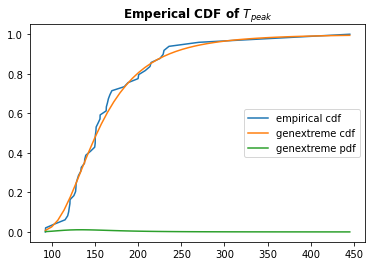


7
Reject the null hypothesis. Confident it DOES NOT come from expon
Reject the null hypothesis. Confident it DOES NOT come from gamma
Accept the null hypothesis. Confident it DOES come from  genextreme
genextreme
fit args: (1.058815728423074, 0.8926803963611483, 0.11688284833632757)
kolmogrov: KstestResult(statistic=0.11790911267434112, pvalue=0.4557923336523432)


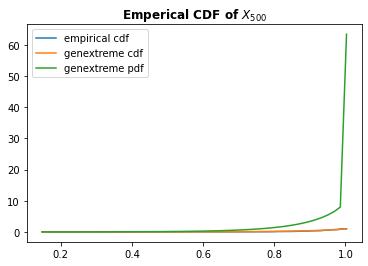

In [62]:
for col in range(features.shape[1]):
    print(col)
    title1 = "Emperical CDF of "
    titles = [ '$N_{50}$','$N_{150}$','$N_{300}$','$D_{50}$', '$D_{150}$','$D_{300}$','$T_{peak}$','$X_{500}$']
    distribution_fitting(features[:,col],title1 + titles[col])
    print("")

*Describe the fitted distributions. Your answer goes here.*

The process here was to give the samples for each feature to the parameter estimators of each distribition, then use those parameters to create a corresponding artificial distribution and finally compare the samples against the artificial distribitions with some statistical tests like Kolmogorov-Smirnov or Chi squared. 

For me, I was only able to use the Kolmogorov-Smirnov test as I have relatively little experience with statistics unfortunately, and this was my first time doing this in python. I tried some of the modules, but ended up using was I could from the scipy package. The process was very helpful for me to understand creating statistical analysis and I am grateful to have done this assignment. 

So I can see here that some hypothesis of these distribution fits were rejected. From the accepted null hypothesis, the graph of the empirical and aritifcial CDF's really help explain the KStest. Visually speaking, we can see that the CDF's are generally following the same trajectory and curvature. The CDF's that have more residual distances between the two lines have a higher D statistic value. This is confirmed visually, compare the CDF of gamma-D150 with a Dstatistic of .179 vs the CDF of genextreme-Tpeak with a dstatistic of .077. You can see that the CDF's in gamma-D150 have much more difference between the sample and the artificial which is why the Dstat is higher. For genextreme-tpeak, we see the CDF lines have much less distance between them, and the dstat is much lower at .077.

## Joint  and conditional probabilities, chain rule and Bayes' Theorem

Lets calculate the probability of having a mild start and a disastrous end of the epidemia. We translate that to the **joint probability** that no more than $4\%$ are infected after $50$ days, i.e., $N_{50}\leq 4\%$ and more than $0.95\%$ die in the end, i.e., $X_{500}>0.95\%$.

In [33]:
n_50 = features[:,0]
x_500 = features[:,7]

n_50_mild = np.where(n_50<=4)
x_500_disaster = np.where(x_500>0.95)

all_cases = features.shape[0]
positive_cases = np.intersect1d(n_50_mild,x_500_disaster).shape[0]
P = positive_cases/all_cases

print("P(Mild start AND A disastrous end)",P)

P(Mild start AND A disastrous end) 0.02


So $P(N_{50}\leq 4\%, X_{500}>0.95\%) \approx 0.02$.

We check the product of the two probabilities $P(N_{50}\leq 4\%)P(X_{500}>0.95\%)$:

In [30]:
mild_start_cases = n_50_mild[0].shape[0]
disaster_cases = x_500_disaster[0].shape[0]

P2 = mild_start_cases/all_cases * disaster_cases/all_cases
print("P(Mild start)*P(Disastrous end)",P2,"... not independent because they are not equal to the previous calculation")

P(Mild start)*P(Disastrous end) 0.1428 ... not independent because they are not equal to the previous calculation


We are not surprised that the result is different from the joint probability as the random variables $N_{50}$ and $X_{500}$ not independent (double-check the results from the correlation analysis).  

What is the **conditional probability** of more than $0.95\%$ die in the end given that we know that no more $4\%$ are infected after $50$ days.

In [17]:
P_AB = positive_cases/mild_start_cases
print(P_AB)

0.058823529411764705


So $P(X_{500}>0.95\%|N_{50}\leq 4\%) \approx 0.0588$.

The product or **chain rule** of probability states that

\begin{align}
P(A,B) &= P(A|B)P(B)\\
P(X_{500}>0.95\%,N_{50}\leq 4\%) &= P(X_{500}>0.95\%|N_{50}\leq 4\%)P(N_{50}\leq 4\%)
\end{align}

And we don't get disappointed:

In [18]:
P_B = mild_start_cases/all_cases;
P = P_AB*P_B
print("Using conditional probabilty rule to confirm:",P)

Using conditional probabilty rule to confirm: 0.02


Let us numerically confirm **Bayes' Theorem** for this case. We'd expect that  

\begin{align}
P(A|B) &= \frac{P(B|A)P(A)}{P(B)}\\
P(X_{500}>0.95\%|N_{50}\leq 4\%) &= \frac{P(N_{50}\leq 4\%|X_{500}>0.95\%)P(X_{500}>0.95\%)}{P(N_{50}\leq 4\%)}
\end{align}

And we don't get disappointed:

In [25]:
# P_A = disaster_cases/all_cases;
P_BA = positive_cases/disaster_cases;
P_AB = P_BA*P_A/P_B
print(P_A, P_BA, P_AB)

0.42 0.047619047619047616 0.05882352941176469


So far, we have looked at the joint (sample) probability of $P(N_{50}\leq n, X_{500}>x)$ for *concrete* bounds $n=4$ and $x=0.95$. Let us now understand the joint (sample) probability of $F(n,x)=P(N_{50}\leq n, X_{500}>x)$ as a *function* of these bounds $n$ and $x$. Since, $0\leq X_{500}\leq 100$ this function is equal to joint (sample) cumulative distribution function: 

\begin{align}
F(n,x) &=\mathit{CDF}_{N_{50},100-X_{500}}(n,100-x)\\
\mathit{CDF}_{N_{50},100-X_{500}}(n,y)&=P(N_{50}\leq n, 100-X_{500}\leq y)
\end{align}

In `Matlab`, we can numerically approximate such a joint $\mathit{CDF}_{X,Y}(x,y)$:

In [ ]:
addpath('/Users/wlomsi/Documents/MATLAB/ecdfbiv');
([n_50, 100-x_500],20,20);
surfc([1:20],[1:20],joint_CDF);

*Interprete this CDF. Your answer goes here.*

Along the X axis we have the number of people that are infected after 50 days, in the range of 0 to 20. Along the y axis, we have the number of people that have died after 500 days, in the range of 0 to 20. Along the z axis, we have the joint probability. This means I can pick say, 2 people infected after 50 days on the x axis, then see the probability of the number of casualties that might occur. So with 2 infected after 50 days, it is highly unlikely to have any casualties. However, with just 5 infected the probability of having casualties is higher (although not necessariy high). Also, if we increase the number of infections to 15, we see that the probability of having at least a few casualties is at least 5 casualties is almost assured, while the probability of having just 1 casuality is very low.

Finally, we compare the emperical PDF the (sample) distribution with the fitted PDF of that distribution. We look at $N_{50}$.

In [ ]:
%%file samplePDF.m
function PDF = samplePDF(sample, pd_fit, verbose)
    [f,xi] = ksdensity(sample); 
    PDF = griddedInterpolant(xi,f);
    if (verbose)
        figure
        plot(xi, PDF(xi));
        hold on;
        plot(xi, pdf(pd_fit,xi));
    end
end

In [ ]:
PDF_n_50 = samplePDF(n_50,pd_n_50, true)

In [ ]:
PDF_x_500 = samplePDF(x_500,pd_x_500, true)

## Self-entropy of an event and entropy of a distribution

We define a function that calculates the entropy of a sample distribution, based on a parameterless sample PDF approximation (calculated with `samplePDF`) and a well-known ditribition with fitted parameters (calculated with `distribution_fitting`). It also computeas the Kullback-Leibler (KL) divergence in both directions.

In [ ]:
%%file fit_sample_entropies.m
function [EntropyFitted, EntropySample, diff_fit_sample, diff_sample_fit] = fit_sample_entropies(sample, pd_fit, PDF)
    EntropyFitted = 0;
    EntropySample = 0;
    diff_fit_sample = 0;
    diff_sample_fit = 0;
    for i=1:length(sample)
        EntropyFitted = EntropyFitted - pdf(pd_fit,sample(i))*log(pdf(pd_fit,sample(i)));
        EntropySample = EntropySample - PDF(sample(i))*log(PDF(sample(i)));
        diff_fit_sample = diff_fit_sample - pdf(pd_fit,sample(i))*(log(pdf(pd_fit,sample(i)))-log(PDF(sample(i))));
        diff_sample_fit = diff_sample_fit - PDF(sample(i))*(log(pdf(pd_fit,sample(i)))-log(PDF(sample(i))));
    end
end

Let's apply this function on the $N_{50}$ sample.

In [ ]:
[EntropyFitted, EntropySample, diff_fit_sample, diff_sample_fit] = fit_sample_entropies(n_50, pd_n_50, PDF_n_50)

*Why is the entropy of $N_{50}$ assuming is proportional to the sample PDF higher that assuming it is proportional to the fitted Gamma distribution? Why are the divergence values different? Your answers go here.* 

The entropy gives us a sense of uncertainty in the distributions while the KL divergence gives us an index of the difference between the two distributions (it's not a measure though). However, the index can be used to explain the similarity. There is uncertainty in both distributions which is because they are very close to each other. However, the divergence shows a big difference. This is due to the asymmetry in KL. 

## References

1. Amira Rachah and Delfim F. M. Torres: Mathematical Modelling, Simulation, and Optimal Control of the 2014 Ebola Outbreak in West Africa. Discrete Dynamics in Nature and Society, Volume 2015, Article ID 842792, https://www.hindawi.com/journals/ddns/2015/842792/.